In [1]:
from IPython.display import clear_output

import torchvision
import numpy as np
import torch
from torch import nn

import model
import utils
from utils import FlatFolderDataset

import matplotlib.pyplot as plt

from tqdm import tqdm

import json

In [2]:
# This is a very useful class that load all the useful config from a json file
class DevEnvironment():
    def __init__(self, config_file):
        '''
        config_file: path to the config file
        '''
        config = json.loads(open(config_file).read())

        self.batch_size = config["batch_size"] if "batch_size" in config else 32

        # The path for the style and content folders
        self.style_path = config["style_path"] if "style_path" in config else "E:\\projects\\42AI\\StyleTransferMirror\\style"
        self.content_path = config["content_path"] if "content_path" in config else "E:\\projects\\42AI\\StyleTransferMirror\\content"

        # Here we load the FlatFolderDataset in a dataload
        # And then wrap it in an infinite loader
        self._style_dataset = FlatFolderDataset(self.style_path)
        style_dataloader = torch.utils.data.DataLoader(self._style_dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.style_loader = utils.infinite_loader(style_dataloader)

        self._content_dataset = FlatFolderDataset(self.content_path)
        content_dataloader = torch.utils.data.DataLoader(self._content_dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.content_loader = utils.infinite_loader(content_dataloader)

        # This is the device used for training
        self.device = torch.device(config["device"]) if "device" in config else torch.device("cuda")

        # Setting up the layers we need on the vgg pretrained encoder
        self.vgg_encoder = model.vgg
        self.vgg_encoder.load_state_dict(torch.load("./model_save/vgg_normalised.pth"))
        self.vgg_encoder = nn.Sequential(*list(self.vgg_encoder.children())[:44])

        # Setting up the image decoder
        self.decoder = model.decoder.to(self.device)

        # And then the Style Attention Network
        self.network : model.MultiLevelStyleAttention = model.MultiLevelStyleAttention(self.vgg_encoder, self.decoder)
        self.network.to(self.device)
        self.network.train()

        # Setting up everything related to the learning rate
        self.lr = config["lr"] if "lr" in config else 1e-4
        self.lr_decay = config["lr_decay"] if "lr_decay" in config else 0.99999
        self.decay_after = config["decay_after"] if "decay_after" in config else 5000

        # Total number of training steps to train
        self.iters = config["iters"] if "iters" in config else 200000

        # Setting up the optimizer with all the parameters
        self.optimizer = torch.optim.Adam([
            {"params": self.network.decoder.parameters()},
            {"params": self.network.sa_module.parameters()}
        ], lr=self.lr)

        # Setting up the weights for the loss calculation
        self.style_weight = config["style_weight"] if "style_weight" in config else 5.0
        self.content_weight = config["content_weight"] if "content_weight" in config else 1.0
        self.identity1_weight = config["identity1_weight"] if "identity1_weight" in config else 50.0
        self.identity2_weight = config["identity2_weight"] if "identity2_weight" in config else 1.0

        # And then some variables about log and saving intervals
        self.save_checkpoint_interval = config["save_checkpoint_interval"] if "save_checkpoint_interval" in config else 1000
        self.log_generated_interval = config["log_generated_interval"] if "log_generated_interval" in config else 20
        self.img_generated_interval = config["img_generated_interval"] if "img_generated_interval" in config else 100
    
    def load_save(self, file_path : str):
        # Loading the dict of all parameters dict from the file located at file_path
        saved = torch.load(file_path, map_location=lambda storage, loc: storage)

        # Loading the different part of the model separatly
        self.network.decoder.load_state_dict(saved["decoder"], strict=False)
        self.network.sa_module.load_state_dict(saved["sa_module"], strict=False)
        self.optimizer.load_state_dict(saved["optimizer"])


In [3]:
# Loading the configs in env variable
env = DevEnvironment("config.json")

In [4]:
# Small function to display stylized content_images with style_images
def save_stylization(content_images, style_images, env : DevEnvironment, i = 0):
    # First clean the gpu memory to unsure enought space
    utils.clean()

    # Using autocast to dynamicly fit content and style on the gpu
    # Using no grad because we don't need to calculate gradient
    with torch.cuda.amp.autocast() and torch.no_grad():
        # Compiling tensors to match all content with all styles
        content_tensors = torch.cat([torch.cat(content_images) for _ in range(len(style_images))]).to(env.device)
        style_tensors = torch.cat([torch.cat([style_images[i] for _ in range(len(content_images))]) for i in range(len(style_images))]).to(env.device)

        # Getting the stylized images
        stylized = env.network(content_tensors, style_tensors, train=False)

        # Save the image using the torchvision utils make_grid
        torchvision.utils.save_image(
            torchvision.utils.make_grid(
                torch.cat([torch.zeros((1, *content_tensors.size()[1:])).to(env.device), content_tensors[:len(content_images)], torch.cat([torch.cat([style_tensors[i*len(content_images):i*len(content_images)+1], stylized[i*len(content_images):(i+1)*len(content_images)]]) for i in range(len(style_images))])]),
                nrow=len(content_images) + 1,
            ),
            f"samples/{str(i+1).zfill(6)}.png",
        )

In [5]:
# This is the last iteration where we stop at last training
# (The same as the one in the saved name we want)
start_iteration = 177000
pbar = tqdm(range(start_iteration, env.iters))

# Dict with the loss history
losses = {"Lc": [], "Ls": [], "loss_lambda1": [], "loss_lambda2": [], "loss": []}
losses_ma = {"Lc": [], "Ls": [], "loss_lambda1": [], "loss_lambda2": [], "loss": []}

# Load the preceding models if not the first training step
if start_iteration != 0:
    env.load_save(f"model_save/{str(start_iteration).zfill(6)}.pt")

  0%|          | 0/23000 [00:00<?, ?it/s]

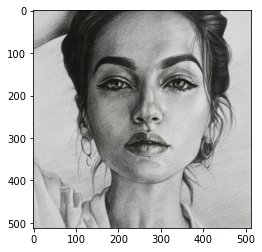

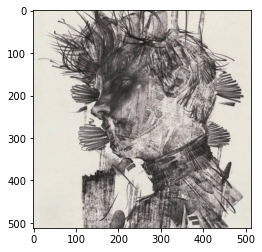

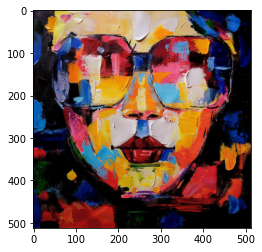

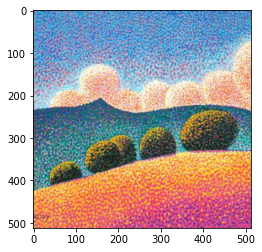

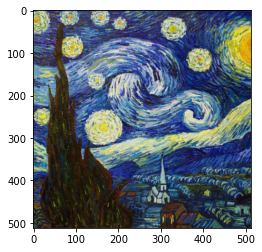

In [6]:
# Use custom style folder to display sample data
custom_style_dataset = FlatFolderDataset("custom_style/")
custom_content_dataset = FlatFolderDataset("custom_content/")
# Don't forget to put at least style image in the custom_style folder
assert(len(custom_style_dataset) > 0)

# This is some manualy selected content images
#indexes = [20811, 114981, 6134, 53197, 88402, 95770]
indexes = range(len(custom_content_dataset))
content_samples = [torch.unsqueeze(custom_content_dataset.__getitem__(index, False), 0) for index in indexes]

# This is some manualy selected style images
indexes = range(len(custom_style_dataset))
style_samples = [torch.unsqueeze(custom_style_dataset.__getitem__(index, False), 0) for index in indexes]

# Show the style images used
for index in indexes:
    batch = torchvision.transforms.ToPILImage()(custom_style_dataset.__getitem__(index, False))
    plt.imshow(batch)
    plt.show()

# Uncomment next line to test the stylisation (will be save on sample/000001.png) 
save_stylization(content_samples, style_samples, env)

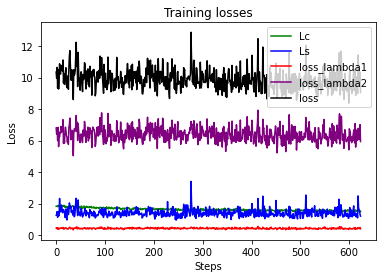

loss: 10.8218994140625, Lc: 1.475973129272461, Ls: 1.1389670372009277, lambda1: 0.4774026572704315, lambda2: 7.729557037353516:  14%|█▍        | 12495/88000 [2:10:26<13:14:59,  1.58it/s]

In [14]:
for i in pbar:
    # Adjust learning rate
    if i + 1 > env.decay_after:
        for param_group in env.optimizer.param_groups:
            param_group['lr'] *= env.lr_decay

    # Autocast is used to manage the type of each weights (fp16, fp32)
    # and make sure all the data fit in the memory without OOM issues
    with torch.cuda.amp.autocast():
        # Load images
        content_images = next(env.content_loader).to(env.device)
        style_images = next(env.style_loader).to(env.device)

        # Get loss from network
        Lc, Ls, loss_lambda1, loss_lambda2 = env.network(content_images, style_images)

        # Combine the losses
        Lc *= env.content_weight
        Ls *= env.style_weight
        loss_lambda1 *=  env.identity1_weight 
        loss_lambda2 *=  env.identity2_weight 
        loss = Lc + Ls + loss_lambda1 + loss_lambda2

    # Then zero grad from the precedent step
    env.optimizer.zero_grad()

    # Compute the new gradients
    loss.backward()

    # Gradient clipping
    for params in env.network.decoder.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)
    for params in env.network.sa_module.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)

    # Take optimization step
    env.optimizer.step()

    # Save the losses
    losses["Lc"].append(Lc.detach().cpu().numpy())
    losses["Ls"].append(Ls.detach().cpu().numpy())
    losses["loss_lambda1"].append(loss_lambda1.detach().cpu().numpy())
    losses["loss_lambda2"].append(loss_lambda2.detach().cpu().numpy())
    losses["loss"].append(loss.detach().cpu().numpy())

    if not (i + 1) % env.log_generated_interval:
        # Save the average of the log_generated_interval precedent losses
        losses_ma["Lc"].append(np.array(losses["Lc"][-env.log_generated_interval + 1:]).mean())
        losses_ma["Ls"].append(np.array(losses["Ls"][-env.log_generated_interval + 1:]).mean())
        losses_ma["loss_lambda1"].append(np.array(losses["loss_lambda1"][-env.log_generated_interval + 1:]).mean())
        losses_ma["loss_lambda2"].append(np.array(losses["loss_lambda2"][-env.log_generated_interval + 1:]).mean())
        losses_ma["loss"].append(np.array(losses["loss"][-env.log_generated_interval + 1:]).mean())

        # Clear the previous loss screen
        clear_output(wait=True)

        # Plot the losses
        plt.plot(range(len(losses_ma["Lc"])), losses_ma["Lc"], 'g', label='Lc')
        plt.plot(range(len(losses_ma["Ls"])), losses_ma["Ls"], 'b', label='Ls')
        plt.plot(range(len(losses_ma["loss_lambda1"])), losses_ma["loss_lambda1"], 'r', label='loss_lambda1')
        plt.plot(range(len(losses_ma["loss_lambda2"])), losses_ma["loss_lambda2"], 'purple', label='loss_lambda2')
        plt.plot(range(len(losses_ma["loss"])), losses_ma["loss"], 'black', label='loss')
        plt.title('Training losses')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    if not (i + 1) % env.img_generated_interval:
        # Saving the stylisation
        save_stylization(content_samples, style_samples, env, i)
        
        # Clean every memory used on the stylisation 
        utils.clean()

    # Don't forget to save the models regularly
    if not (i + 1) % env.save_checkpoint_interval:
        torch.save({
            "decoder": env.network.decoder.state_dict(),
            "sa_module": env.network.sa_module.state_dict(),
            "optimizer": env.optimizer.state_dict()
        }, f"model_save/{str(i+1).zfill(6)}.pt")

    # Monitor the losses at each steps
    pbar.set_description("loss: {}, Lc: {}, Ls: {}, lambda1: {}, lambda2: {}".format(loss.detach().cpu().numpy(), Lc.detach().cpu().numpy(), Ls.detach().cpu().numpy(), loss_lambda1.detach().cpu().numpy(), loss_lambda2.detach().cpu().numpy()))